In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from autoencoder import AutoEncoder
from reader import to_embeddings, get_loader, get_sentence_model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
X_test = pd.read_csv("data/test.csv")['prompt'].tolist()

test_embeddings = to_embeddings(X_test, device)
test_loader = get_loader(test_embeddings)

In [4]:
#input_dim = 384 # Sentence Transformer Embedding Size
# Get input dimension from embeddings shape
input_dim = test_embeddings.shape[1]

model = AutoEncoder(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("checkpoint.pth", weights_only=True))

<All keys matched successfully>

Average Reconstruction Error on Test Set: 0.0011


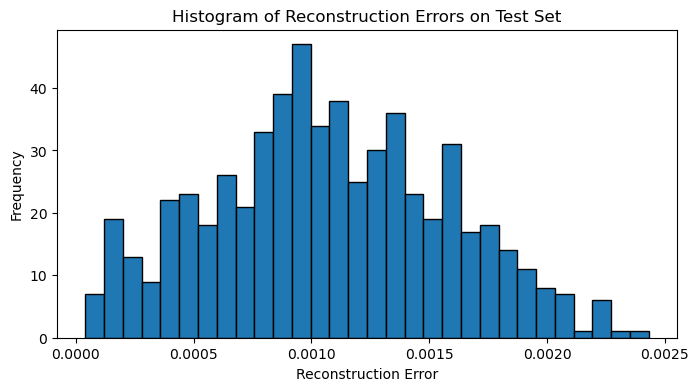

In [5]:
model.eval()

all_errors = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        
        recon_batch = model(batch)

        batch_errors = torch.mean((recon_batch - batch) ** 2, dim=1)
        
        all_errors.extend(batch_errors.cpu().numpy())
        
reconstruction_errors = np.array(all_errors)
print("Average Reconstruction Error on Test Set: {:.4f}".format(np.mean(reconstruction_errors)))

# Plot histogram for visualization
plt.figure(figsize=(8, 4))
plt.hist(reconstruction_errors, bins=30, edgecolor='black')
plt.title("Histogram of Reconstruction Errors on Test Set")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()

## Inference Setup & Calibration

In [6]:
def classify_prompt(prompt, model, sentence_model, threshold):
    emb = sentence_model.encode(prompt, convert_to_tensor=True).clone().detach().to(device)
    emb = emb.unsqueeze(0)

    model.eval()

    with torch.no_grad():
        recon = model(emb)
        error = torch.mean((recon - emb) ** 2, dim=1).item()

    classification = 1 if error < threshold else 0

    return error, classification

threshold_percentile = 95 
threshold = np.percentile(reconstruction_errors, threshold_percentile)
print("Threshold set at the {}th percentile: {:.4f}".format(threshold_percentile, threshold))

Threshold set at the 95th percentile: 0.0019


### More Evaluations

In [7]:
errors = []
classifications = []

sentence_model = get_sentence_model(device)

for prompt in X_test:
    error, classification = classify_prompt(prompt, model, sentence_model, threshold)

    errors.append(error)
    classifications.append(classification)

false_negatives = []
for prompt, classification, error in zip(X_test, classifications, errors):
    if classification == 0:
        false_negatives.append((prompt, error))

FN = len(false_negatives)
TP = len(X_test) - FN

# Calculate Recall and FNR
recall = TP / (TP + FN)
fnr = FN / (TP + FN)

print(f"Recall: {recall:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

Recall: 0.9497
False Negative Rate (FNR): 0.0503


## Testing on a new dataset

In [22]:
from datasets import load_dataset

jbb = load_dataset("JailbreakBench/JBB-Behaviors", "behaviors")
wikiqa = load_dataset("microsoft/wiki_qa")

In [27]:
harmful_prompts = jbb['harmful']['Goal']
questions = list(set(ds['test']['question']))

df_normal = pd.DataFrame({
    'prompt': questions,
    'label': 0
})

df_harmful = pd.DataFrame({
    'prompt': harmful_prompts,
    'label': 1
})

df = pd.concat([df_normal, df_harmful], ignore_index=True)

'how was the toreador fresco completed'

In [28]:
from sklearn.metrics import confusion_matrix

# Assume df is already defined with columns 'prompt' and 'label'
# where label 0 = normal question and 1 = harmful prompt

errors = []
predictions = []

# Iterate over each row in the dataframe
for idx, row in df.iterrows():
    prompt = row['prompt']
    # Classify the prompt (classification: 0 for normal, 1 for harmful)
    error, classification = classify_prompt(prompt, model, sentence_model, threshold)
    errors.append(error)
    predictions.append(classification)

# Add the predictions and errors to the dataframe (optional)
df['predicted'] = predictions
df['error'] = errors

# Compute confusion matrix using the ground truth labels and the model's predictions.
# The matrix will be formatted as:
# [[True Negatives, False Positives],
#  [False Negatives, True Positives]]
cm = confusion_matrix(df['label'], df['predicted'], labels=[0, 1]) 
print("Confusion Matrix (rows: true labels, columns: predicted labels):")
print(cm)

# For harmful prompts (ground truth label = 1), calculate False Negatives and True Positives.
false_negatives = df[(df['label'] == 1) & (df['predicted'] == 0)]
true_positives = df[(df['label'] == 1) & (df['predicted'] == 1)]
FN = len(false_negatives)
TP = len(true_positives)

# Calculate Recall and False Negative Rate (FNR) for harmful prompts.
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
fnr = FN / (TP + FN) if (TP + FN) > 0 else 0

print(f"Recall (for harmful prompts): {recall:.4f}")
print(f"False Negative Rate (FNR) (for harmful prompts): {fnr:.4f}")

Confusion Matrix (rows: true labels, columns: predicted labels):
[[629   4]
 [ 26  74]]
Recall (for harmful prompts): 0.7400
False Negative Rate (FNR) (for harmful prompts): 0.2600


In [10]:
from datasets import load_dataset

ds = load_dataset("microsoft/wiki_qa")

README.md:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/594k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/264k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/6165 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2733 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20360 [00:00<?, ? examples/s]

In [21]:
questions = list(set(ds['test']['question']))

errors = []
classifications = []

for prompt in questions:
    error, classification = classify_prompt(prompt, model, sentence_model, threshold)

    errors.append(error)
    classifications.append(classification)

false_negatives = []
for prompt, classification, error in zip(questions, classifications, errors):
    if classification == 1:
        false_negatives.append((prompt, error))

FN = len(false_negatives)
TP = len(questions) - FN

# Calculate Recall and FNR
recall = TP / (TP + FN)
fnr = FN / (TP + FN)

print(f"Recall: {recall:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

Recall: 0.9937
False Negative Rate (FNR): 0.0063
